In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
from matplotlib import pyplot as plt
import tqdm
import warnings
from itertools import combinations
from geopy.distance import geodesic

In [2]:
g = nx.read_gml("../data/clean/all_routes.gml")

# remove citys with faulty data
g.remove_node("Split")
g.remove_node("Tirana")
g.remove_node("Lyon-St")

## Functions to calculate traveltimes

In [3]:
def get_neighbors_by_type(g:nx.Graph, location:str, type:str) -> List[str]:
    neighbors = []
    if type != "City" and type != "Airport" and type != "Station":
        raise ValueError(f"Unvalid type '{type}'")
    for node in g.adj[location]:
        if g.nodes[node]["type"] == type:
             neighbors.append(node) 
    return neighbors

# calculates time from source_city -> source_airport  -> destination_airport -> destination_city
# 120min - 45min boarding time already included = 75min
def get_airplane_duration(g: nx.Graph, source_city:str, destination_city:str, airport_wait_minutes = 75) -> List[Dict[List[str], int]]:
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Airport")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Airport")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_airport, destination_airport in possible_coombinations:
        route = {
            "nodes": [source_city, source_airport, destination_airport, destination_city],
            "duration": 0
        }
        route["duration"] += g[source_city][source_airport]["duration"]
        route["duration"] += g[source_airport][destination_airport]["duration"]
        route["duration"] += g[destination_airport][destination_city]["duration"]
        route["duration"] += airport_wait_minutes
        durations.append(route)
    return durations

# calculates time from source_city -> destination_city
def get_car_duration(g: nx.Graph, source_city:str, destination_city:str) -> List[Dict[List[str], int]]:
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
    
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    route = {
        "nodes": [source_city, destination_city],
        "duration": g[source_city][destination_city]["duration"]
    }
    
    return [route]

# calculates time from source_city -> source_station -> ... -> destination_station -> destination_city
def get_train_duration(g: nx.Graph, source_city:str, destination_city:str, train_wait_minutes = 10) -> List[Dict[List[str], int]]:
    def filter_train_edges(n1, n2):
        type =  g[n1][n2].get("type", "none")
        return type == "train"
    
    if source_city == destination_city:
        source_city.capitalize()
        destination_city.capitalize()
        warnings.warn("Source and destination city are the same")
        return 0
        
    assert g.has_node(source_city), f"{source_city} is not in network"
    assert g.has_node(destination_city), f"{destination_city} is not in network"

    source_airports = get_neighbors_by_type(g, source_city, type="Station")
    destination_airports = get_neighbors_by_type(g, destination_city, type="Station")
    possible_coombinations = [(source, destination)for source in source_airports for destination in destination_airports]

    durations = []
    for source_station, destination_station in possible_coombinations:
        route = {
            "nodes": [source_city],
            "duration": 0
        }
        subgraph = nx.subgraph_view(g, filter_edge=filter_train_edges)
        shortest_path = nx.shortest_path(subgraph, source=source_station, target=destination_station, weight="duration")
        route["nodes"] += shortest_path + [destination_city]
        route["duration"] = nx.path_weight(g, shortest_path, "duration")
        route["duration"] += g[source_city][source_station]["duration"]
        route["duration"] += g[destination_city][destination_station]["duration"]
        durations.append(route)  
    return durations

## Create a dataframe
To be able to analyse the data we need it in a fitting format.
Lets create a dataframe where every line is a connection between two cities. We want to include the distance and the traveltimes with car, train and plane.

We have 173 cities which means we get around 173^2/2=29929/2 < 15000 which should be no problem to process.

In [4]:
def calculate_distance(city1, city2):
    pos1 = g.nodes[city1]["pos"]
    pos2 = g.nodes[city2]["pos"]
    return geodesic(pos1, pos2).kilometers

In [9]:
# Built a dataframe
data = []
# get all the nodes that are from a 
city_nodes = [node for node in g.nodes if g.nodes[node]["type"] == "City"]

# iterate through city nodes
for city1, city2 in combinations(city_nodes, 2):

    distance = calculate_distance(city1, city2)
    
    # Calculate car_duration
    car_durations = get_car_duration(g, city1, city2)
    car_duration = car_durations[0]["duration"] if car_durations else None
    
    # Calculate train_duration
    try:
        train_durations = get_train_duration(g, city1, city2)
        train_duration = train_durations[0]["duration"] if train_durations else None
    except nx.NetworkXNoPath:
        train_duration = None
    
    # Calculate plane_duration
    plane_durations = get_airplane_duration(g, city1, city2)
    plane_duration = min(route["duration"] for route in plane_durations) if plane_durations else None

    data.append([city1, city2, distance, car_duration, train_duration, plane_duration])

result_df = pd.DataFrame(data, columns=["city1", "city2", "distance", "car_duration", "train_duration", "plane_duration"])


# Include Countries of city1 and city2:

all_data = pd.read_csv("../data/clean/all_data.csv")
country_information = all_data[["city", "Country"]]
# some cities appear more than once. This leeds to problems when merging
country_information = country_information.drop_duplicates(subset='city')

result_df = result_df.merge(country_information, left_on='city1', right_on='city', how='left')
result_df = result_df.rename(columns={'Country': 'country1'})
result_df = result_df.drop('city', axis=1)

result_df = result_df.merge(country_information, left_on='city2', right_on='city', how='left')
result_df = result_df.rename(columns={'Country': 'country2'})
result_df = result_df.drop('city', axis=1)


# Add Column fastest_transportation

result_df['fastest_transportation'] = result_df[['car_duration', 'train_duration', 'plane_duration']].idxmin(axis=1)

# Map the column names to transportation modes (train, car, plane)
transportation_mapping = {'car_duration': 'car', 'train_duration': 'train', 'plane_duration': 'plane'}
result_df['fastest_transportation'] = result_df['fastest_transportation'].map(transportation_mapping)


result_df.head()

,city1,city2,distance,car_duration,train_duration,plane_duration,country1,country2,fastest_transportation
0,Graz,Innsbruck,306.702101,298,370.800000,216.000000,Austria,Austria,plane
1,Graz,Klagenfurt,98.595632,96,189.383333,192.216667,Austria,Austria,car
2,Graz,Linz,162.456030,150,197.900000,216.216667,Austria,Austria,car
3,Graz,Salzburg,197.716117,182,257.016667,211.716667,Austria,Austria,car
4,Graz,Vienna,144.572948,133,166.583333,214.833333,Austria,Austria,car


## Data Analysis

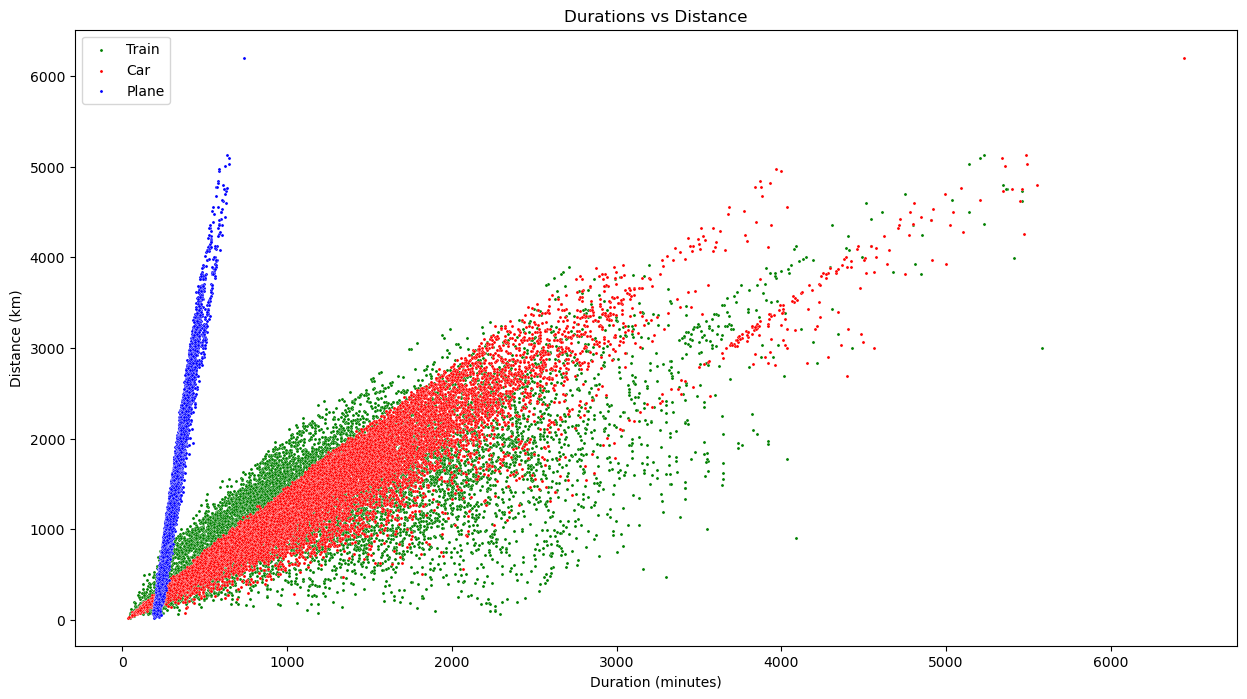

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.scatterplot(data=result_df, x='train_duration', y='distance', label='Train', color='green', s=5)
sns.scatterplot(data=result_df, x='car_duration', y='distance', label='Car', color='red', s=5)
sns.scatterplot(data=result_df, x='plane_duration', y='distance', label='Plane', color='blue', s=5)

plt.title('Durations vs Distance')
plt.xlabel('Duration (minutes)')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()

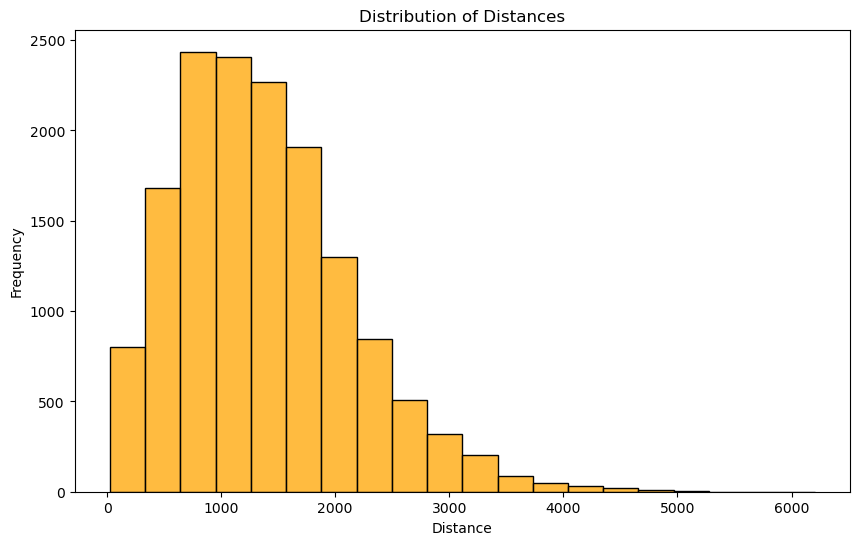

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for distances
sns.histplot(result_df['distance'], bins=20, color='orange', edgecolor='black', ax=ax)
ax.set_title('Distribution of Distances')
ax.set_xlabel('Distance')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

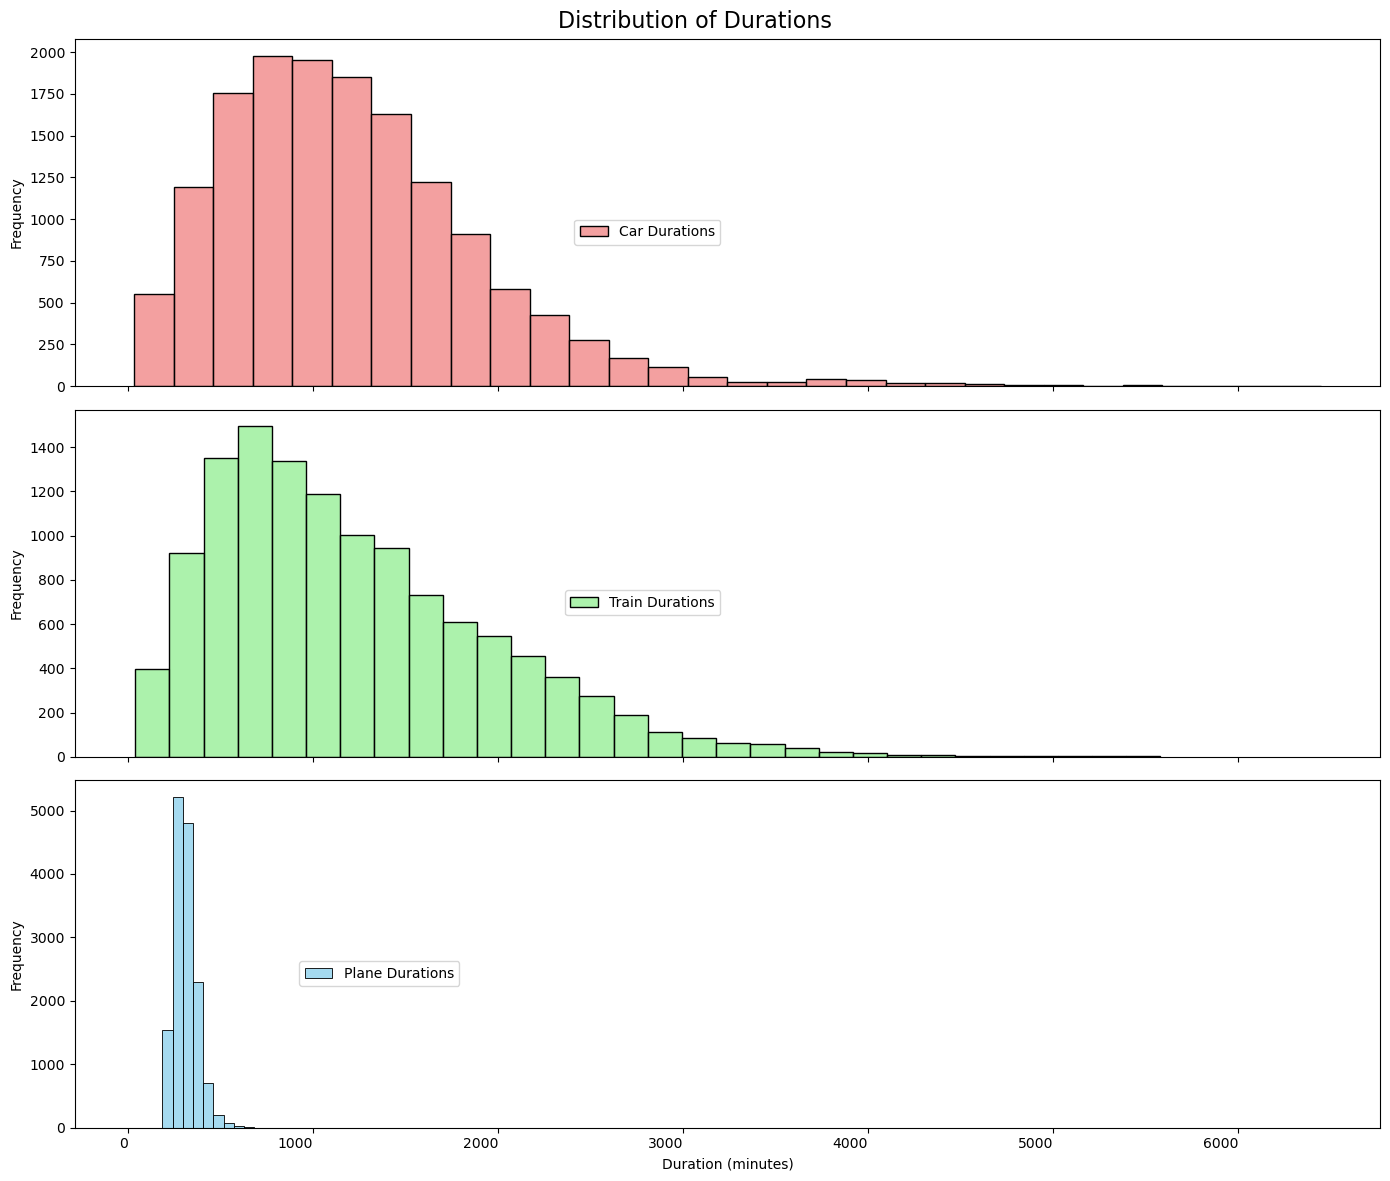

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

plt.suptitle('Distribution of Durations', fontsize=16)

# Plot histogram for car durations
sns.histplot(result_df['car_duration'].dropna(), bins=30, color='lightcoral', edgecolor='black', ax=ax1)
ax1.set_xlabel('Duration (minutes)')
ax1.set_ylabel('Frequency')
ax1.legend(['Car Durations'], bbox_to_anchor=(0.5, 0.5), fancybox=True, fontsize='medium')

# Plot histogram for train durations
sns.histplot(result_df['train_duration'].dropna(), bins=30, color='lightgreen', edgecolor='black', ax=ax2)
ax2.set_xlabel('Duration (minutes)')
ax2.set_ylabel('Frequency')
ax2.legend(['Train Durations'], bbox_to_anchor=(0.5, 0.5), fancybox=True, fontsize='medium')

# Plot histogram for train durations
sns.histplot(result_df['plane_duration'].dropna(), bins=10, color='skyblue', edgecolor='black', ax=ax3)
ax3.set_xlabel('Duration (minutes)')
ax3.set_ylabel('Frequency')
ax3.legend(['Plane Durations'], bbox_to_anchor=(0.3, 0.5), fancybox=True, fontsize='medium')

plt.tight_layout()
plt.xticks(ha='right')
plt.show()

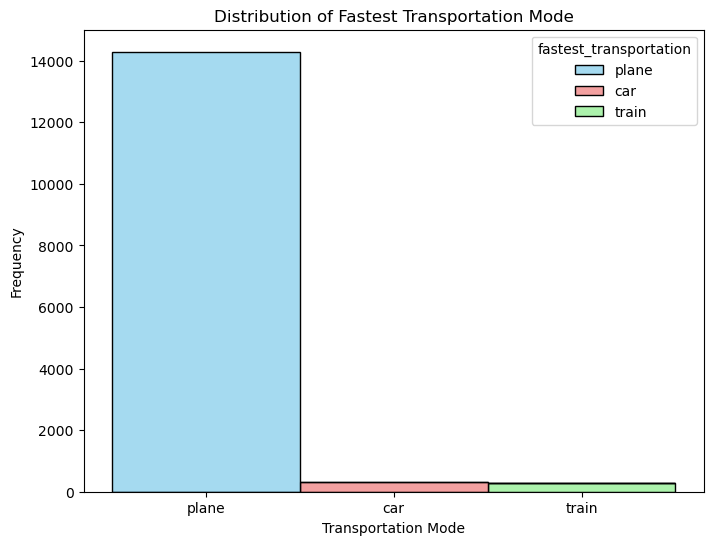

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(data=result_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Transportation Mode')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()

## Closer look at travels under 500km

In [15]:
filtered_df = result_df[result_df['distance']< 500]

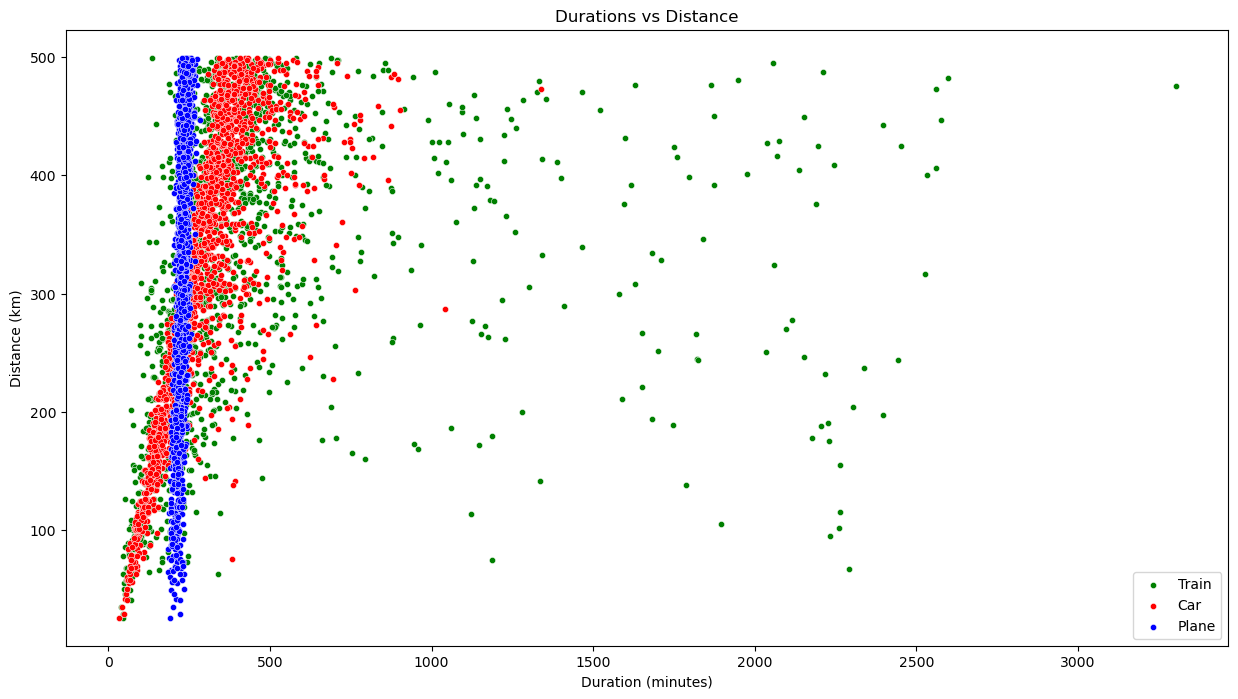

In [16]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=filtered_df, x='train_duration', y='distance', label='Train', color='green', s=20)
sns.scatterplot(data=filtered_df, x='car_duration', y='distance', label='Car', color='red', s=20)
sns.scatterplot(data=filtered_df, x='plane_duration', y='distance', label='Plane', color='blue', s=20)

plt.title('Durations vs Distance')
plt.xlabel('Duration (minutes)')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()

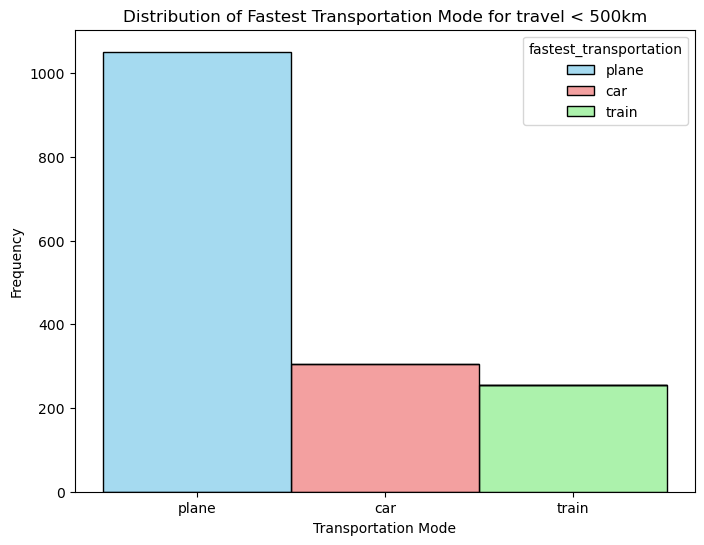

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Transportation Mode for travel < 500km')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()

## Closer look at France, Belgium and the Netherlands

In [18]:
filtered_df = result_df[(result_df['country1'].isin(['France', 'Belgium', 'Netherlands'])) & 
                        (result_df['country2'].isin(['France', 'Belgium', 'Netherlands']))]

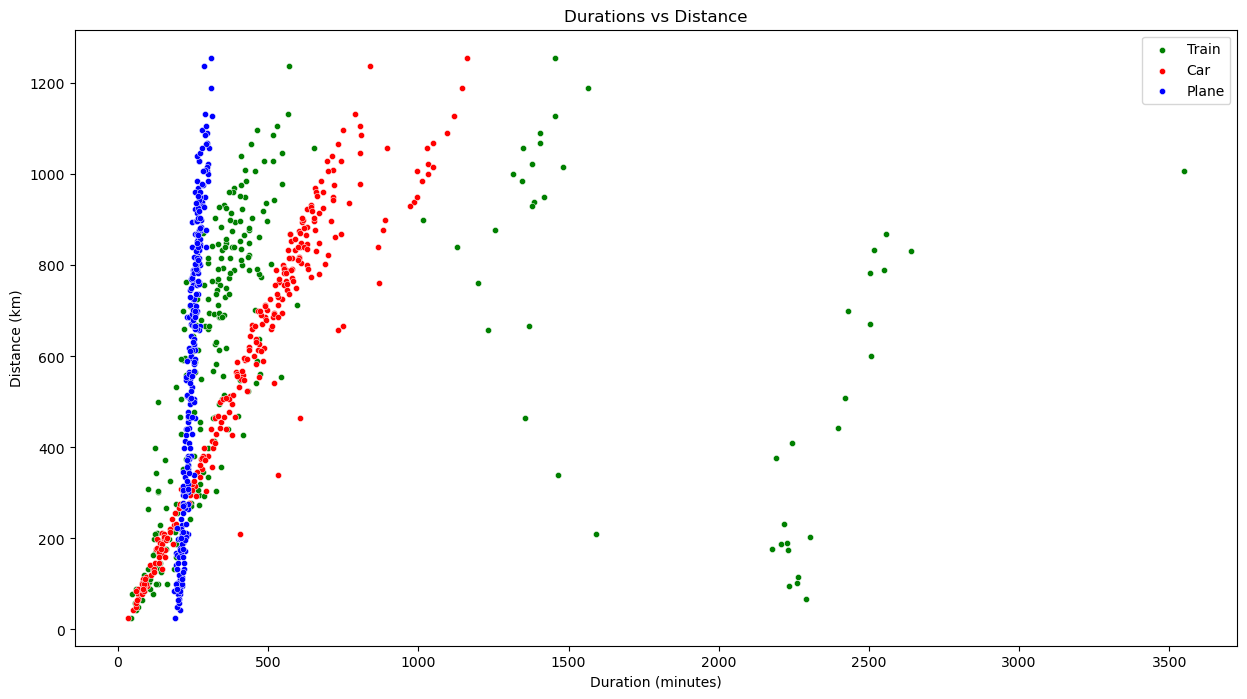

In [19]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=filtered_df, x='train_duration', y='distance', label='Train', color='green', s=20)
sns.scatterplot(data=filtered_df, x='car_duration', y='distance', label='Car', color='red', s=20)
sns.scatterplot(data=filtered_df, x='plane_duration', y='distance', label='Plane', color='blue', s=20)

plt.title('Durations vs Distance')
plt.xlabel('Duration (minutes)')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()

Problem: 
lat long of stations not correct (most are fine but some are problematic)
we can see many outliers -> location of the station is wrong

  node [
    id 404
    label "Lille Station"
    city "Lille"
    type "Station"
    pos 59.95597
    pos 11.04918               =     Lillestrom, Norway      !=    Lille, France
  ]

Only to these trainstations:
427 = Station_München duration: 1412
423 = Station_Hamburg duration: 835
419 = Station_Dresden duration: 1259
228 = City_Lilleduration: 1045.2166666666667

it seems all the distances were calculated with the Station in Norway


Probably best to remove these 
The problematic ones are between 5 and 10 percent

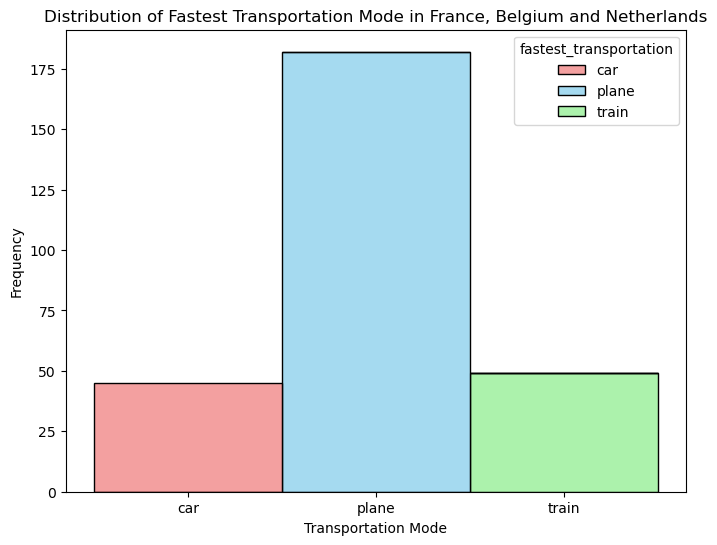

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Transportation Mode in France, Belgium and Netherlands')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()

## Closer look at Norway, Sweden and Denmark

In [21]:
filtered_df = result_df[(result_df['country1'].isin(['Norway', 'Sweden', 'Denmark'])) & 
                        (result_df['country2'].isin(['Norway', 'Sweden', 'Denmark']))]

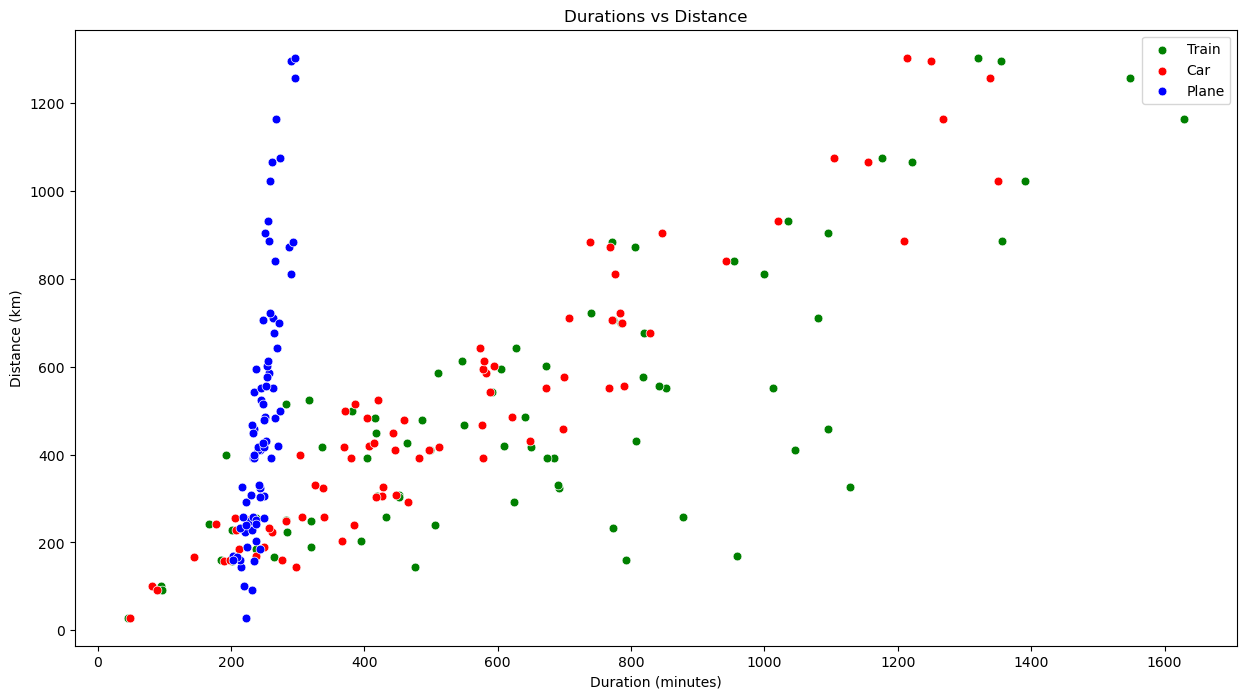

In [22]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=filtered_df, x='train_duration', y='distance', label='Train', color='green', s=40)
sns.scatterplot(data=filtered_df, x='car_duration', y='distance', label='Car', color='red', s=40)
sns.scatterplot(data=filtered_df, x='plane_duration', y='distance', label='Plane', color='blue', s=40)

plt.title('Durations vs Distance')
plt.xlabel('Duration (minutes)')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()

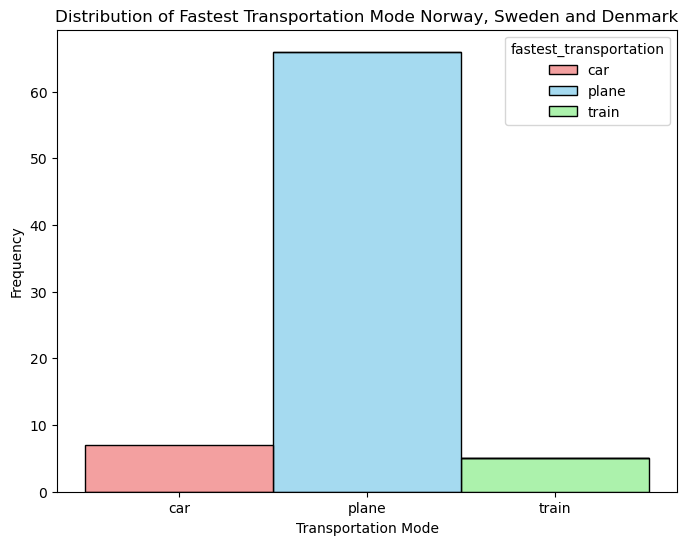

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_df, x='fastest_transportation', hue='fastest_transportation', multiple='stack',
             palette={'car': 'lightcoral', 'train': 'lightgreen', 'plane': 'skyblue'},
             edgecolor='black')

plt.title('Distribution of Fastest Transportation Mode Norway, Sweden and Denmark')
plt.xlabel('Transportation Mode')
plt.ylabel('Frequency')

plt.show()